<font color='red'> Если нет необходимых библиотек инсталируем их </font>

In [31]:
#!pip install torch
#!pip install torchvision

In [32]:
import matplotlib.pyplot as plt
import torch
import random
import numpy as np
import torchvision.datasets

# Лабораторная №1

In [33]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [34]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels

In [35]:
X_train = X_train.float().numpy()

In [36]:
X_train.shape

(60000, 28, 28)

# Выбор варианта

Всего 60000 картинок, каждый выбирает картинки из диапазона $[6000(n-1)+1,6000\cdot n]$ где $n$- номер по списку.
Постройте гистограмму для ответов (y_train) и убедитесь, что у вас нет дисбаланса классов. Если есть дисбаланс, устраните его удалением соответствующего класса или удалением картинок. Порог для преобразования в $\{0,1\}$(см. ниже) установите равным:
$$
thr = 0.45 + (n-1)/100
$$

## Преобразуем данные в нули и единицы.

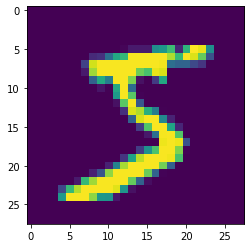

In [37]:
plt.imshow(X_train[0, :, :])
plt.show()

In [38]:
thr = 0.45 # Номер варианта см. список группы
X_train[X_train>thr] = 1
X_train[X_train<thr] = 0

## Картинка после преобразования

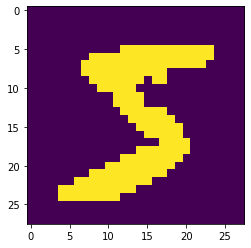

tensor(5)


In [39]:
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

## Применим EM-алгоритм для смеси распределений Бернулли

Найти выражения для E-шага и M-шага для смеси C штук распределений
Бернулли 
$$
p(X\mid \theta) = \prod_{i=1}^D \sum_{c=1}^C p (x_i|\mu_c)\pi_c, \quad x_i\in \mathbf{R}^N,  \quad \mu\in\mathbf{R}^N
$$
$$
p(z\mid\mu_c) = \prod_{j=1}^N \mu_{cj}^{z_j}(1-\mu_{cj})^{1-z_j}, \quad  z_j\in\{0,1\},
$$

где параметры модели $\theta = \{\mu_{11},\dots,\mu_{1N},\dots,\mu_{C1},\dots,\mu_{CN}, \pi_1,\dots, \pi_C\}$. 

<font color='red'> В отличие от модели на семинаре здесь параметр $\mu$ это вектор размера $N$ !!! </font>

## Задание 1: получить выражения для E-шага


Получить формулы для E-шага. 
$$
q(t_i) = p (t_i\mid x_i,\theta)
$$
$$
\gamma_{i,c} = q(t_i=c) = \dots
$$


<b>Важный трюк 1:</b> при вычислении произведений, можно использовать логарифмирование, при этом, чтобы избежать нулей под логарифмом, можно нули заменять на очень маленькие числа. 

<b>Важный трюк 2:</b> важно избегать числовых ошибок. В какой-то момент вам может понадобиться вычислить формулу следующего вида (если использовать логарифмирование (см. трюк 1)): $\frac{e^{y_i}}{\sum_j e^{y_j}}$, которая называется _softmax_. Когда вы вычисляете показатели степени больших чисел, некоторые числа могут стать бесконечными. Этого можно избежать, разделив числитель и знаменатель на $e^{\max(y)}$: 
$$
\frac{e^{y_i-\max(y)}}{\sum_j e^{y_j - \max(y) )}}.
$$ 
После этого преобразования максимальное значение в знаменателе будет равно единице. Все остальные члены будут вносить меньшие значения. Итак, чтобы вычислить нужную формулу, вы сначала вычитаете максимальное значение из каждой компоненты в векторе $\mathbf{y}$, а затем вычисляете все остальное, как и раньше.


## Задание 2: реализовать E-шаг

In [15]:
def E_step(X, pi, mu):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (D x N), data points
    pi: (C), mixture component weights 
    mu: (C x N), mixture component means
    
    Returns:
    gamma: (D x C), probabilities of clusters for objects
    """
    D = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    N = mu.shape[1] # dimension of each object
    gamma = np.zeros((D, C)) # distribution q(T)
    eps = 1e-12
    #TO DO
    return gamma

## Задание 3:  получить выражения для M-шаг


$$
{\cal L}(\theta,q) = \sum_i\sum_c \gamma_{i,c}\left(\sum_{j=1}^N x_{ij}\log(\mu_{cj}) + (1-x_{ij})\log(1-\mu_{cj})+ \log\pi_c\right) \to \max_{\theta}
$$

Составить функцию Лагранжа и получить выражения для $\theta$.

## Задание 4: реализовать M-шаг

In [16]:
def M_step(X, gamma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (D x N), data points
    gamma: (D x C), probabilities of clusters for objects
    Returns:
    pi: (C)
    mu: (C x N)
    """
    D = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    N = X.shape[1] # dimension of each object
    #TO DO

    return pi, mu

## Задание 5: получить функцию потерь

Наконец, нам нужна функция для отслеживания сходимости. Для этой цели мы будем использовать вариационную нижнюю границу $\mathcal{L}$. Мы остановим наши итерации EM, когда $\mathcal{L}$ перестанет сильно изменяться.  Также полезно проверить, что эта функция никогда не уменьшается во время тренировки. Если это так, у вас есть ошибка в вашем коде.

<b>Реализуем функцию, которая будет вычислять $\mathcal{L}$</b> 

$$\mathcal{L}(\theta, q) =\mathbb{E}_{q(T)}\log \frac{p(X,T | \theta)}{q(T|\theta)}  =  \dots$$ 

## Задание 6: реализовать функцию потерь

Не забываем использовать <b>трюк 1</b>.

In [17]:
def compute_vlb(X, pi, mu, gamma):
    """
    Each input is numpy array:
    X: (D x N), data points
    gamma: (D x C), distribution q(T)  
    pi: (C)
    mu: (C x N)
    sigma: (C x N x N)
    
    Returns value of variational lower bound
    """
    D = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    N = X.shape[1] # dimension of each object

    eps =1e-9
    #TO DO

    return loss

## Задание 7: внедрение процедуры обучения

Теперь, когда у нас есть шаг E, шаг M и VLB, мы можем реализовать тренировочный цикл. Мы будем инициализировать значения $\pi$, $\mu$ и $\Sigma$ некоторыми случайными числами, обучать до тех пор, пока $\mathcal{L}$ не перестанет меняться, и возвращать полученные точки. Мы также знаем, что алгоритм EM сходится к локальным оптимумам. Чтобы найти лучшие локальные оптимумы, мы перезапустим алгоритм несколько раз с разных (случайных) начальных позиций. Каждое тренировочное испытание должно останавливаться либо при достижении максимального количества итераций, либо когда относительное улучшение становится меньше заданного допуска $$\left|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal {L}_{i-1}}\right| \le \text{rtol}$$.

<b>Начальные данные:</b>
Параметры $\pi_c$ можно задавать одинаковыми, при это не забываем, что сумма равна единице.  Параметры $\mu$ можно моделировать равномерно на отрезке [0.25, 0.75], далее их надо отнормировать.

Также в код можно добавить обработку ситуации, когда целевая функция возвращает nan.

In [18]:
def rand_pi(C):
    pi = np.zeros(C)
    #TO DO
    return pi

def rand_mu(X, C, N):
    mu = np.zeros(C,N)
    # TO DO
    return mu.T


def train_EM(X, C=10, rtol=1e-3, max_iter=10, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (D, N), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None
    loss_prev = None
    

    for _ in range(restarts):
        print('New restart')
        loss = None
        curr_rel_loss = None
        pi0 = rand_pi(C)
        mu0 = rand_mu(X, C, d) 
        loss = None
        for i in range(max_iter):
            pi, mu = pi0, mu0
            gamma = E_step(X, pi, mu)
            pi, mu  = M_step(X, gamma)
            loss = compute_vlb(X, pi, mu, gamma)
            pi0 = pi
            mu0 = mu
            if loss_prev != None:
                curr_rel_loss = np.abs(loss_prev - loss)/np.abs(loss_prev)
                loss_prev = loss
            else:
                loss_prev = loss
            if curr_rel_loss!=None and curr_rel_loss < rtol:
                break
            print(f'Step: {i}')
        if best_loss!=None:
            if loss>best_loss:
                best_loss = loss
                best_mu = mu
                best_pi = pi
        else:
            best_loss = loss
            best_mu = mu
            best_pi = pi

    return best_loss, best_pi, best_m

## Задание 8

Обучить модель и ответить на следующие вопросы.

1. Построить графики для всех математических ожиданий в виде цифр (т.е. преобразовать вектора в матрицы) Похожи ли получившиеся средние на цифры? (С=10)
2. Построить несколько картинок для цифр из обучающей выборки и соответствующих математических ожиданий на одном графике для одного класса. Проделать это для нескольких классов. Как можно интерпретировать результат?
3. Разбить на обучающую и тестовую выборки, и определить оптимальное кол-во кластеров с помощью графиков правдоподобия для обучения и теста. 
4. Попробовать улучшить результат (варьировать различные параметры), подумать как оценивать качество.
5. Написать вывод.
